In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train/"
test_path = "./new_val_in/new_val_in/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [6]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)
test_dataset = ArgoverseDataset(data_path=test_path)

### Create a loader to enable batch processing

In [7]:
batch_sz = 512

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    #inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = [numpy.dstack([scene['p_in']]) for scene in batch]
    #out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    out = [numpy.dstack([scene['p_out']]) for scene in batch]
    agent_id = [[scene['agent_id']] for scene in batch]
    track_id = [numpy.dstack([scene['track_id']]) for scene in batch]
    inp = torch.Tensor(inp).float()
    out = torch.Tensor(out).float()
    return [inp, out, track_id, agent_id]
    #return [inp, out]

def test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    #inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = [numpy.dstack([scene['p_in']]) for scene in batch]
    agent_id = [[scene['agent_id']] for scene in batch]
    track_id = [numpy.dstack([scene['track_id']]) for scene in batch]
    inp = torch.Tensor(inp).float()
    return [inp, track_id, agent_id]
    #return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=3200, shuffle = False, collate_fn=test_collate, num_workers=0)

### Deep Learning Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class myModel(nn.Module):
    """This class defines your deep learning model that extends a Module class
      The constructor of your class defines the layers of the model. 
      The forward() function defines how to forward propagate 
      input through the defined layers of the model.

    """

    def __init__(self):
        super(myModel, self).__init__()
        #self.linear1 = nn.Linear(19, 240*30)
        #self.relu = nn.ReLU()
        #self.linear2 = nn.Linear(240*30, 30)
        
        self.linear1 = nn.Linear(19, 240*30)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(240*30, 30)
        
        #self.hidden_dim = 2048*2
        #self.num_layers = 3
        #self.lstm = nn.LSTM(240, self.hidden_dim, num_layers = self.num_layers, batch_first = True)
        #self.linear = nn.Conv1d(self.hidden_dim, 240, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        #x, _ = self.lstm(x)
        #x = x.transpose(1, 2)
        #x = self.linear(x)
        #x = x.transpose(1, 2)
        
        return x
    
    def forward_test(self, x):
        with torch.no_grad():
            x = self.linear1(x)
            x = self.relu(x)
            x = self.linear2(x)
        return x


In [ ]:
model = myModel()
learning_rate = 1e-3
l = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr =learning_rate )

loss_ema = -1
model.train()
for epoch in range(1500):
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        
        inp = inp.float()
        out = out.float()
        
        mixed = torch.cat([inp, out],2).transpose(1, 2).reshape(-1, 49, 240).float()
        y_pred = model(mixed[:, :-1,])[:, -30:]
        y_pred = y_pred.reshape((-1, 30,60, 4)).transpose(1, 2)
        
        loss = l(y_pred, out) ** 0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if loss_ema < 0:
            loss_ema = loss
        loss_ema = loss_ema*0.99+loss*0.01
        
        if epoch%25 == 0:
            print('epoch {}, loss_ema {}, loss {}'.format(epoch, loss_ema.item(), loss.item()))
            
        break
        
print('epoch {}, loss {}'.format(epoch, loss.item()))

In [ ]:
model.eval()
for epoch in range(2):
    for i_batch, sample_batch in enumerate(test_loader):
        inp, out, track_id, agents = sample_batch
        flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
        inp = inp.type(torch.cuda.FloatTensor)
        
        mixed = torch.cat([inp, out],2).transpose(1, 2).reshape(-1, 49, 240)
        y_pred = model(inp.reshape(-1, 49, 240))[:, -30:]
        y_pred = y_pred.reshape((-1, 30,60, 4)).transpose(1, 2)
        
        print(y_pred)

## Old Code

In [16]:
model = myModel()
model.train()

learning_rate = 1e-4
l = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr =learning_rate )
loss_ema = -1

for epoch in range(2000):
    
    correct = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, track_id, agents = sample_batch
        flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
        inp = inp #.cuda()
        out = out #.cuda()
        
        batch_sz = inp.size(0)
        agent_sz = inp.size(1)
        
        predict_in = []
        y_train = []
        
        
        for i in range(batch_sz):
            
            agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
            #if i ==0:
                #print(agents[i])
            predict_in.append(inp[i, agent_id,:, 0:2].t().transpose(1, 0).flatten().tolist())
            y_train.append(out[i, agent_id,:, 0:2].t().transpose(1, 0).flatten().tolist())
            
        
        predict_in = torch.FloatTensor(predict_in)
        y_train = torch.FloatTensor(y_train)
        
        #print(predict_in.shape)
        #print(y_train.shape)
        
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        x_train = model(predict_in.type(torch.float))
        
        #RMSE as kaggle competition has it
        loss = torch.sqrt(l(x_train, y_train.type(torch.float)))
        if loss_ema < 0:
            loss_ema = loss
        loss_ema = loss_ema*0.99+loss*0.01
            
        #print(x_train)
        #print(y_train)
        #backward propagation: calculate gradients
        loss.backward()

        #update the weights
        optimizer.step()
        
        
        if (epoch%25 == 0 or epoch == 499):
            print('epoch {}, loss_ema {}, loss {}'.format(epoch, loss_ema.item(), loss.item()))
        break


epoch 0, loss_ema 2211.722412109375, loss 2211.722412109375
epoch 25, loss_ema 1819.86376953125, loss 105.49495697021484
epoch 50, loss_ema 1430.7257080078125, loss 37.456146240234375
epoch 75, loss_ema 1118.08154296875, loss 18.681961059570312
epoch 100, loss_ema 873.8159790039062, loss 18.346202850341797
epoch 125, loss_ema 683.6777954101562, loss 17.843725204467773
epoch 150, loss_ema 535.702392578125, loss 19.07477569580078


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import random

agent_id = 0


for epoch in range(1):
    
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, track_id, agents = sample_batch
        flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
        inp = inp #.cuda()
        out = out #.cuda()
        
        batch_sz = inp.size(0)
        agent_sz = inp.size(1)
        
        predict_in = []
        y_train = []
        
        
        for i in range(batch_sz):
            
            agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
            #if i ==0:
                #print(agents[i])
            predict_in.append(inp[i, agent_id,:, 0:2].t().float())
            y_train.append(out[i, agent_id,:, 0:2].t().float())
            
        
        predict_in = torch.stack(predict_in)
        y_train = torch.stack(y_train)
        
        #print(predict_in.shape)
        #print(y_train.shape)
        
        #clear out the gradients from the last step loss.backward()
        
        x_train = model.forward_test(predict_in)
        
        #RMSE as kaggle competition has it
        loss = torch.sqrt(l(x_train, y_train))
        
        
        test_losses.append(loss.item())
        
        
        fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()   
        for i in range(batch_sz):
            
            axs[i].xaxis.set_ticks([])
            axs[i].yaxis.set_ticks([])

            # first two feature dimensions are (x,y) positions
            axs[i].scatter(x_train[i,:,0], x_train[i,:,1])
            axs[i].scatter(y_train[i,:,0], y_train[i,:,1])
    break

In [69]:
import csv

file_string = './output_batch_sz_128_linear.csv'

labels = ['ID']
for i in range(60):
    labels.append('v' + str(i+1))


write = True
if (write):
    with open(file_string, 'w', newline ='') as file:    
        write = csv.writer(file)
        write.writerow(labels)


model.eval()
result = []
#for epoch in range(13):
for i_batch, sample_batch in enumerate(test_loader):
    inp, track_id, agents = sample_batch
    flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
    inp = inp #.cuda()
        
    batch_sz = inp.size(0)
        
    for i in range(batch_sz):
        #print(i)    
        agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
        predict_in = (inp[i, agent_id,:, 0:2].t().transpose(1, 0).flatten().tolist())
        
        predict_in = torch.FloatTensor(predict_in)
        
        x_train = model.forward_test(predict_in.type(torch.float))
        
        x_train = x_train.tolist()
        
        x_train.insert(0, float(agents[i][0].replace('-', '')))
            
        #print(x_train)
        if (write):
            with open(file_string, 'a+', newline ='') as file:    
                write = csv.writer(file)
                write.writerow(x_train)
            
    break

## 1 batch

epoch 0, i 0, loss_ema 1655.3358154296875, loss 1655.3358154296875
epoch 0, i 64, loss_ema 959.0897216796875, loss 73.25421905517578
epoch 0, i 128, loss_ema 525.6539916992188, loss 23.224782943725586
epoch 0, i 192, loss_ema 298.9344787597656, loss 52.1901741027832
epoch 0, i 256, loss_ema 180.05484008789062, loss 30.195619583129883
epoch 0, i 320, loss_ema 114.60310363769531, loss 62.52608108520508
epoch 0, i 384, loss_ema 80.06090545654297, loss 34.43927764892578
epoch 0, i 448, loss_ema 62.410709381103516, loss 38.41350555419922
epoch 50, i 0, loss_ema 16.42490577697754, loss 22.071258544921875
epoch 50, i 64, loss_ema 16.476022720336914, loss 7.4602227210998535
epoch 50, i 128, loss_ema 17.123716354370117, loss 12.620437622070312
epoch 50, i 192, loss_ema 18.516742706298828, loss 31.541954040527344
epoch 50, i 256, loss_ema 17.12021827697754, loss 11.234814643859863
epoch 50, i 320, loss_ema 17.299354553222656, loss 11.06428337097168
epoch 50, i 384, loss_ema 15.93598747253418, lo

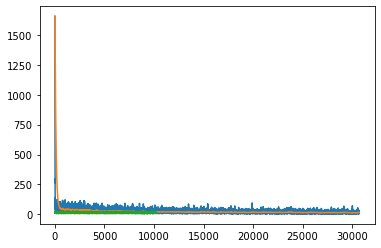

In [20]:
import matplotlib.pyplot as plt

model = myModel() #.cuda()
model.train()
#learning_rate = 0.0000001
learning_rate = 1e-4
l = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr =learning_rate )
loss_ema = -1

losses = []
losses_ema = []

agent_id = 0
for epoch in range(60):
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, track_id, agents = sample_batch
        flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
        inp = inp #.cuda()
        out = out #.cuda()
        
        batch_sz = inp.size(0)
        agent_sz = inp.size(1)
        
        for i in range(batch_sz):
            
            agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
            #if i ==0:
                #print(agents[i])
            predict_in = inp[i, agent_id,:, 0:2].t()
            
            x_train = model(predict_in.type(torch.float))
            
            #calculate the loss
            y_train = out[i, agent_id,:, 0:2].t()
            
            #RMSE as kaggle competition has it
            loss = torch.sqrt(l(x_train, y_train.type(torch.float)))
            if loss_ema < 0:
                loss_ema = loss
            loss_ema = loss_ema*0.99+loss*0.01
            
            #print(x_train)
            #print(y_train)
            #backward propagation: calculate gradients
            loss.backward()

            #update the weights
            optimizer.step()

            #clear out the gradients from the last step loss.backward()
            optimizer.zero_grad()
            
            losses.append(loss.item())
            losses_ema.append(loss_ema.item())
        
            if (epoch%50 == 0 and i%64 == 0):
                print('epoch {}, i {}, loss_ema {}, loss {}'.format(epoch, i, loss_ema.item(), loss.item()))
            
        break   

print('epoch {}, i {}, loss_ema {}, loss {}'.format(epoch, i, loss_ema.item(), loss.item()))

test_losses = []

for epoch in range(20):
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, track_id, agents = sample_batch
        flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
        inp = inp #.cuda()
        out = out #.cuda()
        
        batch_sz = inp.size(0)
        agent_sz = inp.size(1)
        
        for i in range(batch_sz):
            
            agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
            #if i ==0:
                #print(agents[i])
            predict_in = inp[i, agent_id,:, 0:2].t()
            
            x_train = model.forward_test(predict_in.type(torch.float))
            
            #calculate the loss
            y_train = out[i, agent_id,:, 0:2].t()
            
            #RMSE as kaggle competition has it
            loss = torch.sqrt(l(x_train, y_train.type(torch.float)))
            if loss_ema < 0:
                loss_ema = loss
            loss_ema = loss_ema*0.99+loss*0.01
            
            #print(x_train)
            #print(y_train)
            #backward propagation: calculate gradients
            #loss.backward()
            
            test_losses.append(loss.item())
            if (epoch%50 == 0 and i%64 == 0):
                print('epoch {}, i {}, loss {}'.format(epoch, i, loss.item()))
            
        break


plt.plot(losses, label="Training loss")
plt.plot(losses_ema, label="EMA  training loss")
plt.plot(test_losses, label="Validation loss")
plt.show()

In [80]:
labels = ['ID']
for i in range(60):
    labels.append('v' + str(i+1))
print(labels)

['ID', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60']


In [83]:
import csv

file_string = './output_batch_sz_512_epoch_400.csv'

write = True
if (write):
    with open(file_string, 'w', newline ='') as file:    
        write = csv.writer(file)
        write.writerow(labels)


model.eval()
result = []
#for epoch in range(13):
for i_batch, sample_batch in enumerate(test_loader):
    inp, track_id, agents = sample_batch
    flat_track_id = numpy.array(track_id)[:][:, :, 0, 0]
        
    inp = inp #.cuda()
        
    batch_sz = inp.size(0)
        
    for i in range(batch_sz):
            
        agent_id = numpy.where(flat_track_id[i][:] == (agents[i]))[0][0]
        
        predict_in = inp[i, agent_id,:, 0:2].t()
            
        x_train = model.forward_test(predict_in.type(torch.float))
        x_train = x_train.transpose(1, 0).flatten().tolist()
            
            #print(x_train)
            #print(agents[i][0].replace('-', ''))
        x_train.insert(0, float(agents[i][0].replace('-', '')))
            
            #print(x_train)
        if (write):
            with open(file_string, 'a+', newline ='') as file:    
                write = csv.writer(file)
                write.writerow(x_train)
            
    break

### Visualize the batch of sequences

In [ ]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out, track_id = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out, track_id = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break